## COMP_SCI_7417 - Applied Natural Language Processing - Assignment 2

#### Name: Rizal Hamdan Arigusti
#### ID: a1939989

Dataset and source code are available on this Github Repository:

https://github.com/rizalhamdana/comp-sci-7417-assignment-2


In [ ]:
import requests
import pandas as pd
import time
import os
import json
import string
import spacy
import matplotlib.pyplot as plt
import ast
from collections import Counter

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 

COLLECTED_RAW_DATA = "collected_data/stackoverflow_raw_data.csv"
FILTERED_RAW_DATA = "collected_data/stackoverflow_raw_data_with_accepted_answers_only.csv"
CATEGORIZED_DATA = "collected_data/stackoverflow_categorized.csv"

BASE_URL = "https://api.stackexchange.com/2.3"
SEARCH_API_URL = "/search/advanced"
ANSWER_API_URL = "/answers"
ACCESS_TOKEN = "" ### EMPTIED PURPOSEFULLY - AUTHOR SECRET
API_KEY = "" ### EMPTIED PURPOSEFULLY - AUTHOR SECRET


## 1. Data Collection

### 1.1 Fetch Data to StackExchange API

Since data was collected by calling StackExchange API, the first step to do is to understand the API specification itself. There are several API URL/endpoint that were used to collect the Stackoverflow posts/questions, such as:

1. `/search/advanced` 

    To collect all questions with several advanced filter query parameters such as:

    - `tagged`: 
    
        what specific tags that are attached to the questions. In this case is "nlp".
    
    - `filter`: 
    
        What kind of filter that is expected to do by the endpoint. In this case, "withbody" value is used to   make the endpoint includes questions' body (description) in the response.
    
    - `pagesize`:

        How many questions that are included in every endpoint call's response, which in this case is set to 100.

    - `page`:

        What page is called to the API. This is important, as the API limits only 100 questions maximum in every call, therefore calling the API for multiple pages is needed to collect around 20000 questions.


2. `/answers/{ids}`

    To collect all the accepted answers of the corresponded questions. There is only one path parameter that is required to set. 

    - `ids`:
        This is the IDs of a question's answer. In this case, only accepted answers were included. Since the API supports the batch requests in this endpoint, multiple accepted answers' ids from different questions can be set to this path parameters by adding `;` character to the end of every id (e.g 19020;19010;400190).


However, there are several limitations of using StackExchange API. These limitations are API endpoint hit daily quota (200 hits every day) and unable to access more than page 25. Since there are only 100 questions maximum in every page when calling `/search/advanced` API endpoint, it means we can only get 2500 questions maximum. Therefore, to fix this, a simple OAuth2 was implemented to get the API_KEY and ACCESS_TOKEN from StackExchange API. By getting these API_KEY and ACCESS_TOKEN, the API hit daily quota is increased and page more than 25 can be accessible. To use them, we only need to pass their values to `key` and `access_token` query parameters respectively in every API call. A detail explaination about how to get the API_KEY and ACCESS_TOKEN can be [seen here](https://github.com/rizalhamdana/comp-sci-7417-assignment-2/blob/master/README.md#how-to-get-stack-exchange-access-token).

Therefore, below is the implementation code of my data collection.

In [3]:
def fetch_api(url, params):
    response = requests.get(url=url, params=params)
    if response.status_code != 200:
        print("FAILED TO FETCH API!!!")
        print(response.json())
        return False, None
    
    response_body = response.json()
    if len(response_body["items"]) < 1:
        print("NO ITEMS ANYMORE")
        print(response_body)
        return False, response_body

    return True, response.json()
    
def build_questions_data(items: list):
    all_rows = []
    for item in items:
        row = {
            "title": item["title"],
            "description_raw": item["body"],
            "tags": item["tags"],
            "creation_date": datetime.fromtimestamp(item["creation_date"]),
            "view_count": item["view_count"], 
            "score": item["score"],
            "link": item["link"]
        }
        if "answer_count" in item.keys():
            row["answer_count"] = item["answer_count"]
        else:
            row["answer_count"] = 0
        
        if "accepted_answer_id" in item.keys():
            row["accepted_answer_id"] = item["accepted_answer_id"]
            
        all_rows.append(row)
    return all_rows

def build_answers_data(answers):
    rows = []
    for answer in answers:
        row = {
            "answer_id": answer["answer_id"],
            "accepted_answer_description_raw": answer["body"]
        }
        rows.append(row)
        
    return rows

def build_accepted_answers_path_param(questions_data):
    accepted_answer_ids = []
    for question in questions_data:
        if not "accepted_answer_id" in question.keys():
            continue
        accepted_answer_ids.append(str(question["accepted_answer_id"]))
    return ";".join(accepted_answer_ids)

def merge_questions_and_answers(questions_data, answers_data):
    questions_dataframe = pd.DataFrame(questions_data)
    answers_dataframe = pd.DataFrame(answers_data)
    merged = pd.merge(questions_dataframe, answers_dataframe, left_on='accepted_answer_id', right_on='answer_id', how='left')
    merged = merged.drop(["answer_id"], axis=1)
    return merged

def import_questions(tags:list, export_path, has_accepted_answer=False, pagesize=100, site="stackoverflow", start_page=1, end_page=None):
    total_fetched = 0
    tag_string = ";".join(tags)
    has_more = True
    
    questions_url = BASE_URL + SEARCH_API_URL
    questions_query_param = {
        "site": site,
        "pagesize": pagesize,
        "tagged": tag_string,
        "filter": "withbody",
        "key": API_KEY,
        "access_token": ACCESS_TOKEN,
    }
    if has_accepted_answer:
        questions_query_param["accepted"] = has_accepted_answer
        
    answers_query_param = {
        "site": site,
        "filter": "withbody",
        "pagesize": pagesize,
        "key": API_KEY,
        "access_token": ACCESS_TOKEN,
    }
    while has_more:
        file_exist = os.path.isfile(export_path)
        questions_query_param["page"] = start_page
        
        is_success, questions_response_body = fetch_api(questions_url, questions_query_param)
       
        if not is_success:
            break
        
        time.sleep(2)
    
        questions_data = build_questions_data(questions_response_body["items"])
        
        answers_ids_path_param = build_accepted_answers_path_param(questions_data)
        answers_url = BASE_URL + ANSWER_API_URL + "/" + answers_ids_path_param
        
        is_success, answers_response_body = fetch_api(answers_url, answers_query_param)
        

        if not is_success:
            break    
        
        answers_data = build_answers_data(answers_response_body["items"])
        
        merged_questions_answers = merge_questions_and_answers(questions_data, answers_data)
        
        merged_questions_answers["tags"] = merged_questions_answers["tags"].apply(json.dumps)
        merged_questions_answers.to_csv(export_path, mode="a", header=not file_exist, index=False, encoding="utf-8")
        
        total_fetched += merged_questions_answers.shape[0]
        print(f"TOTAL FETCHED QUESTIONS: {total_fetched}", end='\r', flush=True)
        
    
        has_more = questions_response_body["has_more"]
        start_page += 1
        
        if type(end_page) == int and start_page > end_page:
            break
        
        time.sleep(2)
   

In [ ]:
# import_questions(["nlp"], COLLECTED_RAW_DATA, pagesize=100, start_page=1, site="stackoverflow", end_page=210)

## Above code purposefully to be commented to avoid the marker to fetch API again 

In [252]:
raw_data = pd.read_csv(COLLECTED_RAW_DATA, encoding="utf-8")
print(f"Total Fetched Posts: {raw_data.shape[0]}")

Total Fetched Posts: 20415


### 1.2 Exploratory Data Analysis

After all the data were collected, we did some exploratory data analysis. This analysis includes: 

- Number of questions that have accepted answers
- Number of questions every year
- Most common nlp-related tags in StackOverflow

In [258]:
### Reference: ChatGPT 1
def visualize_bar_chart(labels, counts, title, rotation=None, width=0.8, kind="bar", show_count_on_bar=False):
    if kind == "barh":
        plt.barh(labels, counts, height=width)
        plt.xlim(0, max(counts) * 1.05)
        # plt.xticks(count, rotation=rotation)
    else:
        plt.bar(labels, counts, width=width)
        plt.ylabel('Count')
        plt.xticks(labels, rotation=rotation)
        plt.tight_layout()
        if show_count_on_bar:
            for i, count in enumerate(counts):
                plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom')
    plt.title(title)
    plt.show()
        

#### 1.2.1 Questiosn with Accepted Answers

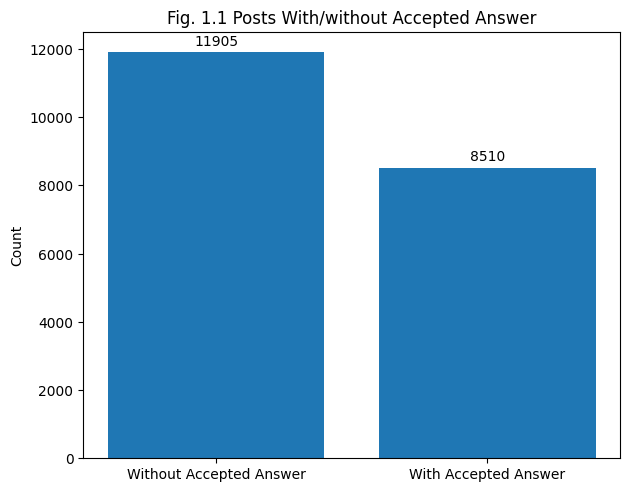

In [254]:
no_accepted_answer_count = raw_data["accepted_answer_id"].isna().sum()
has_accepted_answer_count = raw_data["accepted_answer_id"].notna().sum()

visualize_bar_chart(['Without Accepted Answer', 'With Accepted Answer'],
                    [no_accepted_answer_count, has_accepted_answer_count], 
                    "Fig. 1.1 Posts With/without Accepted Answer",
                    show_count_on_bar=True)

As can be seen on Fig. 1.1, there were 8510 nlp-related questions that have accepted answers. As instructed before, we will only used this kind of questions for further operations and analysis. Which means finally in the end, we will only categorize 8510 NLP related questions using the chosen model.

#### 1.2.2 Number of Questions Every Year

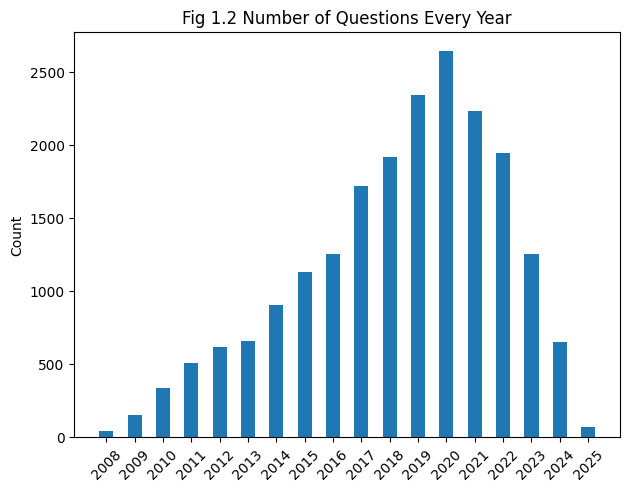

In [210]:
raw_data["creation_date"] = pd.to_datetime(raw_data['creation_date'], errors='coerce')

raw_data['creation_year'] = raw_data['creation_date'].dt.year

year_counts = raw_data.groupby('creation_year').size()
years = year_counts.index.to_numpy()
counts = year_counts.values
visualize_bar_chart(years, counts, 'Fig 1.2 Number of Questions Every Year', rotation=45, width=0.5)

As can be seen in **Figure 1.2**, there was a steady increase trend in the number of NLP related questions from 2008 to 2020. This might indicate an increase of interest and activity in the field of NLP during this period. However, from 2021 onwards, the number of questions rapidly declined and reached only around 500 questions in 2024. This decline trend might be driven by the maturity of NLP related libraries or developers and researchers had shifted to other platforms including Generative AI application like ChatGPT, Claude, Gemini, etc.

#### 1.2.3 Most Common NLP Related Tags

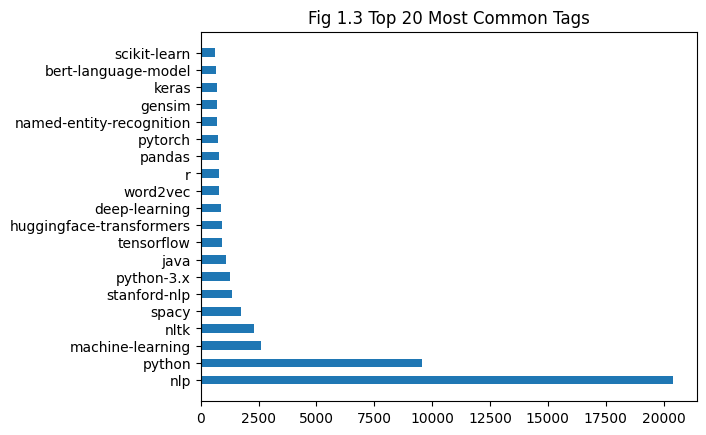

In [212]:
all_tags = raw_data['tags'].dropna().apply(ast.literal_eval)
flat_tags = [tag for sublist in all_tags for tag in sublist]
tag_counts = pd.Series(Counter(flat_tags)).sort_values(ascending=False).head(20)

tags = tag_counts.index.to_numpy()
counts = tag_counts.values
visualize_bar_chart(tags, counts , 'Fig 1.3 Top 20 Most Common Tags', width=0.5, kind="barh")

As can be seen on Fig 1.3, There are some other common nlp-related tags that were attached within all the imported questions. We can see that Python has become the most used programming language for NLP along with its libraries, including NLTK, Spacy, Tensorflow, Pytorch, Pandas, and many more. From these tags only, we can give an overview to the newcomers of NLP that they need some basic knowledge in Python and its common NLP libraries. This will help them in navigating their learning process if they want to focus in this field. 

## 2. Preprocessing

As discussed before, there were 8510 questions that have accepted answers. All of these questions will be used for categorization and gain insights from them. Therefore, the next step that we have to do is to filter all 20000+ questions. Herewith the code implementation

In [220]:
filtered_dataset = raw_data[raw_data['accepted_answer_id'].notna()]
filtered_dataset.to_csv(FILTERED_RAW_DATA, mode="a", header=True, index=False, encoding="utf-8")

After we only used SO Questions with accepted answers only, several preprocessing techniques were applied. These techniques are:

- HTML Tags and Attached Codes Removal
- Lowercasing
- Punctuations Removal
- Stopwords Removal 

### 2.1 HTML Tags and Attached Codes Removal

All the HTML tags that are contained in the raw textual data column were removed. These tags are considered as noise words, and has no meaningful impact in the task that have been done or even can negatively affect the performance of the models. 

Additionally, All the attached code in the description of questions and answers were separated into different column. Although this study does not use these attached codes – as they are also considered as noise words too –, they were kept them in separate columns as it might be needed in the future for different kind of NLP task.

In [13]:
def extract_code_blocks(html):
    soup = BeautifulSoup(html, 'html.parser')
    code_blocks = []
    for pre in soup.find_all('pre'):
        code = pre.find('code')
        if code:
            block_html = f"<pre><code>{code.decode_contents()}</code></pre>"
            code_blocks.append(block_html)
            pre.extract() 
            
    codeblocks_html = '\n'.join(code_blocks) if code_blocks else None
    description_html = str(soup).strip() if soup else None
    return pd.Series([description_html, codeblocks_html])

def clean_html_tags(html):
    soup = BeautifulSoup(html, 'html.parser')
    
    # Tags to completely remove
    tags_to_remove = [
        'script', 'style', 'code', 'pre', 'a', 'button', 'img', 'iframe', 'input',
        'svg', 'table', 'thead', 'tbody', 'tfoot', 'tr', 'td', 'th'
    ]
    
    for tag in soup(tags_to_remove):
        tag.decompose()
    
    # Extract visible text
    text = soup.get_text(separator=' ', strip=True)
    
    # Clean up excessive whitespace
    cleaned = ' '.join(text.split())
    
    return cleaned if cleaned else None

In [222]:

extracted_code_block_dataframe = filtered_dataset.copy()

extracted_code_block_dataframe[["non_code_desc", "attached_code_blocks"]] = extracted_code_block_dataframe["description_raw"].apply(
    extract_code_blocks)

extracted_code_block_dataframe[["non_code_answer", "attached_answer_code_blocks"]] = extracted_code_block_dataframe["accepted_answer_description_raw"].apply(
    extract_code_blocks)


In [223]:
non_html_tags_desc_dataframe = extracted_code_block_dataframe.copy()
non_html_tags_desc_dataframe["non_html_description"] = non_html_tags_desc_dataframe["non_code_desc"].apply(clean_html_tags)
non_html_tags_desc_dataframe["non_html_answer"] = non_html_tags_desc_dataframe["non_code_answer"].apply(clean_html_tags)

In [227]:
non_html_tags_desc_dataframe[["title", "non_html_description", "non_html_answer", "attached_code_blocks", "attached_answer_code_blocks", "link"]]

,title,non_html_description,non_html_answer,attached_code_blocks,attached_answer_code_blocks,link
0,Save and reuse TfidfVectorizer in scikit learn,I am using TfidfVectorizer in scikit learn to ...,"Firstly, it's better to leave the import at th...","<pre><code>loc=open('vectorizer.obj','w')\npic...",<pre><code>from sklearn.feature_extraction.tex...,https://stackoverflow.com/questions/30843011/s...
3,NameError: name &#39;init_empty_weights&#39; i...,I am trying to set up hugging face locally and...,"Try using this version, it should resolve the ...",<pre><code>NameError: name 'init_empty_weights...,<pre><code>transformers==4.50.3\n</code></pre>,https://stackoverflow.com/questions/79559702/n...
8,Natural Language Processing Tag definitions,When parsing and tagging the words with OpenNL...,The tags are part-of-speech tags or syntactic ...,<pre><code>The movie was really good\n\n\-S - ...,None,https://stackoverflow.com/questions/21514270/n...
13,Why does Presidio with spacy nlp engine not re...,I'm using spaCy with the pl_core_news_lg model...,The configuration file is missing the 'labels_...,"<pre><code>import spacy\n\nnlp = spacy.load(""p...",<pre><code> labels_to_ignore:\n - O\n</cod...,https://stackoverflow.com/questions/79549787/w...
20,Store images instead of showing in a server,I am running the code found on this in my serv...,I can't test it but ... I checked and it uses ...,<pre><code>skip_tokens = [1] # skip the speci...,<pre><code>import matplotlib.pyplot as plt\n\n...,https://stackoverflow.com/questions/79501178/s...
...,...,...,...,...,...,...
20407,NLP classify sentences/paragraph as funny,Is there a way to classify a particular senten...,"There is research on this, it's called . It's ...",None,None,https://stackoverflow.com/questions/548951/nlp...
20408,Algorithm for separating nonsense text from me...,I provided some of my programs with a feedback...,How about just using some existing implementat...,None,None,https://stackoverflow.com/questions/501675/alg...
20409,"Contextual Natural Language Resources, Where D...",Where can i find some .Net or conceptual resou...,To find resources in part of speech tagging (a...,None,None,https://stackoverflow.com/questions/127238/con...
20413,Shell script to find bigrams,"I'm making a shell script to find bigrams, whi...",Just replace the paste line with this: This wi...,<pre><code>#tokenise words\ntr -sc 'a-zA-z0-9....,<pre><code>paste out1 out2 | grep -v '\..'\n</...,https://stackoverflow.com/questions/245082/she...


### 2.2 Lowercasing, Punctuation Removal, and Stopwords Removal

Lowercasing is one of the essentials preprocessing steps as it standardized the text that we have. Because computer considers the two same words written in different cases as different, lowercasing ensures the uniformity in the text representation and might simplify subsequent analysis (Bhavar, 2024).  

Another major step in the text preprocessing is punctuation and stopwords removal. Removing punctuation is crucial as the punctuation characters often do not have any significant semantical meaning and just add more noises into the data (Mistry, 2024). As important as removing punctuations, stopwords (the words that occur commonly across all documents) is needed to remove as they are not very discriminative and give minimal significance in some of NLP tasks, especially tasks like classification or information retrieval (Hardeniya et al., n.d.).

In [18]:
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
stop_words = set(stopwords.words('english'))
def lowerize(text):
    if not text:
        return text
    return text.lower()

def remove_punctuations(text):
    if not text:
        return text
    
    return text.translate(text.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    if not text:
        return text
    words = text.split(" ")
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return " ".join(filtered_words)

def lemmatize(text):
    if not text:
        return text
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]

    return ' '.join(lemmatized_tokens)


In [ ]:
preprocessed_dataset = non_html_tags_desc_dataframe.copy()

## Lowerize
preprocessed_dataset["title"] = preprocessed_dataset["title"].apply(lowerize)
preprocessed_dataset["preprocess_description"] = preprocessed_dataset["non_html_description"].apply(lowerize)
preprocessed_dataset["preprocess_answer"] = preprocessed_dataset["non_html_answer"].apply(lowerize)
preprocessed_dataset

## Remove Punctuations
preprocessed_dataset["title"] = preprocessed_dataset["title"].apply(remove_punctuations)
preprocessed_dataset["preprocess_description"] = preprocessed_dataset["preprocess_description"].apply(remove_punctuations)
preprocessed_dataset["preprocess_answer"] = preprocessed_dataset["preprocess_answer"].apply(remove_punctuations)

## Remove Stopwords
preprocessed_dataset["title"] = preprocessed_dataset["title"].apply(remove_stopwords)
preprocessed_dataset["preprocess_description"] = preprocessed_dataset["preprocess_description"].apply(remove_stopwords)
preprocessed_dataset["preprocess_answer"] = preprocessed_dataset["preprocess_answer"].apply(remove_stopwords)



In [228]:
preprocessed_dataset[["title", "preprocess_description", "preprocess_answer", "link"]]

,title,preprocess_description,preprocess_answer,link
0,save reuse tfidfvectorizer scikit learn,using tfidfvectorizer scikit learn create matr...,firstly better leave import top code instead w...,https://stackoverflow.com/questions/30843011/s...
3,nameerror name 39initemptyweights39 defined us...,trying set hugging face locally im running iss...,try using version resolve issue,https://stackoverflow.com/questions/79559702/n...
8,natural language processing tag definitions,parsing tagging words opennlp wondering tags e...,tags partofspeech tags syntactic categories s...,https://stackoverflow.com/questions/21514270/n...
13,presidio spacy nlp engine recognize organizati...,im using spacy plcorenewslg model extract name...,configuration file missing labelstoignore fiel...,https://stackoverflow.com/questions/79549787/w...
20,store images instead showing server,running code found server would like store ima...,cant test checked uses remove shouldnt show g...,https://stackoverflow.com/questions/79501178/s...
...,...,...,...,...
20407,nlp classify sentencesparagraph funny,way classify particular sentenceparagraph funn...,research called interdisciplinary area takes ...,https://stackoverflow.com/questions/548951/nlp...
20408,algorithm separating nonsense text meaningful ...,provided programs feedback function unfortunat...,using existing implementation bayesian spam fi...,https://stackoverflow.com/questions/501675/alg...
20409,contextual natural language resources start,find net conceptual resources start working na...,find resources part speech tagging natural lan...,https://stackoverflow.com/questions/127238/con...
20413,shell script find bigrams,im making shell script find bigrams works sort...,replace paste line filter lines contain period...,https://stackoverflow.com/questions/245082/she...


## 3. WordCloud Generation

As instructed, we need to generate a WordCloud to give us an overview some common topics that are discussed in Stack Overflow. However, since in every question description and answer, there must be some noise words that make us difficult to extract nlp-related terms. Therefore, to handle this, excluding noise words is a solution when we use the WordCloud generator library. After several repeatitions to list all the noise words, we finally can get a meaningful nlp-related wordcloud that can be seen in **Fig. 3.1**

In [ ]:
def non_verb_text(texts):
    whole_texts = ""
    for text in texts:
        if not text:
            continue
        doc = nlp(text)
        filtered_words = [token.text for token in doc if token.pos_ not in ["VERB", "PRON"]]
        filtered_text = " ".join(filtered_words)
        whole_texts = f"{whole_texts} {filtered_text}"
    return whole_texts


# all_text = ' '.join(preprocessed_dataset['preprocess_description'].astype(str))
whole_text  = non_verb_text(preprocessed_dataset["title"])

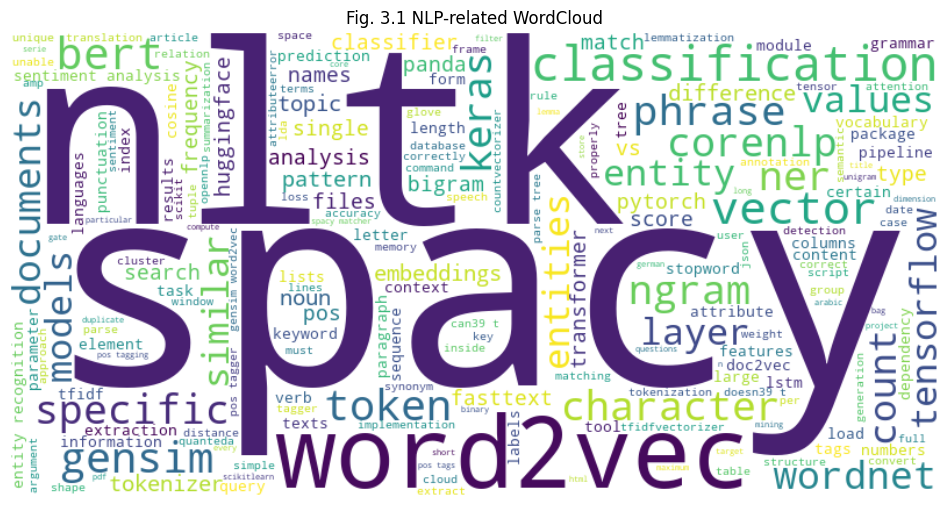

In [261]:
### Reference ChatGPT 2
noise_words = {
    
    "error", "issue", "problem", "fix", "solution", "help",
    "does", "work", "unexpected", "undefined", "null", "none",
    "variable", "function", "method", "class", "object",
    "loop", "condition", "array", "list", "dictionary",
    "python", "java", "javascript", "php", "c#", "c++",
    "react", "angular", "django", "flask", "mysql", "mongodb",
    "debug", "traceback", "exception", "segmentation",
    "runtime", "syntax", "import", "file", "line", "code",
    "return", "print", "log", "input", "output", "example", "using", "like", 
    "would", "use", "need", "want", "following", "get", "however", "also", "could",
    "trying", "im", "something", "look", "tried", "thank", "getting", "working", 
    "seem", "one", "better", "good", "try", "instead", "etc",
    "question", "way", "currently", "used", "examples", "without", "looks", "first",
    "string", "find", "last", "possible", "sentence", "word", "words", "text",
    "cant", "say", "please", "sentences", "current", "seems", "since", "mean", "already", 
    "follow", "well", "much", "many", "given", "different", "know", 
    "still", "thanks", "you", "data", "two", "best", "give", "able",
    "column", "document", "dont", "result", "new",
    "another", "code", "set", "create", "value", "number", "time", "order", "run", "test",
    "tag", "feature", "file", "format", "name", "term", "label", "train", "row",
    "id", "add", "part", "size", "result", "matrix", "version", "include",
    "r", "datum", "nlp", "natural", "language", "dataframe", "model",
    "dataset", "data", "corpus", "corpu", "english", "pretraine", "pretrained", 
    "parser", "strings", "stanford", "training", "processing", "can", "not", "csv", 
    "typeerror", "valueerror", "algorithm", "api", "within", "access", "library", "c", 
    "multiple", "download", "rows", "row", "similarity", "regular", "expression", "regex", "common", "v",
    "machine", "learning", "efficient", "google", "custom"
}
wordcloud = WordCloud(stopwords=noise_words, width=800, height=400, background_color='white', random_state=42).generate(whole_text)

# Display it
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Fig. 3.1 NLP-related WordCloud")
plt.show()

As can be seen from image above, there are many topics that are covered in Stack Overflow. Some NLP-related Python libraris such as NLTK, Spacy, Gensim, Wordnet, etc., are frequently mentioned in StackOverflow Questions and Answers. In addition, several NLP-related tasks are also discussed on this platform, including text classification, named entity recognition, sentiment analysis, and clustering. Finally, many vector embedding terms like BERT and TF-IDF are also visible on this WordCloud. 

## 4. Categorization

In [24]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim

c:\Users\LENOVO\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\LENOVO\anaconda3\envs\tf_gpu\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Given there is no predefined ground truth labels, two unsupervised learning models were used to classify SO questions into specific categories. These models drawn from clustering and topic modeling approaches and successfully extracted 10 categories from a dataset of 8510 SO questions that have accepted answers. In the clustering approach, K-Means was selected as the specific model of choice, while for the topic modeling approach, Latent Dirichlet Allocation (LDA) was chosen as the representative method. 

These two models were chosen as they give a flexibility to choose how many categories that are about to extract. This is important because every category will be manually interpreted and named based on its most frequent words. By specifying the number of categories – 10 categories in this case –, we ensure the classification is granular enough to capture different NLP domains while remaining manageable for human interpretation.

To do the categorization, we initially combine the title, description, and answer into one column in order to make full text that will be converted into chosen vector embeddings.


In [25]:
preprocessed_dataset["combined"] = preprocessed_dataset['title'].str.cat(preprocessed_dataset['preprocess_description'].astype(str), sep=' ')
preprocessed_dataset["combined"] = preprocessed_dataset['combined'].str.cat(preprocessed_dataset["preprocess_answer"].astype(str), sep=" ")

As discussed before, LDA and K-Means models are selected to categorize the collected SO questions. These two models can give the flexibility to choose how many categories that we want to extract. This flexibility also makes the topic modeling and clustering become more comparable and easier to evaluate which one is better for the given task. For the number of categories to extract, this study selected 10 number of categories. Choosing too few topics (e.g. 3-5) can result overly broad categories, while too many topics (e.g. 20+) may lead to redundant clusters. Therefore 10 topics can be middle ground between those two.

Additionally, some experiments cases are conducted not only depending on the models that were utilized, but also on the vector embeddings/semantics applied. This might be important as the choice of vector embeddings can significantly impact the performance of certain models (Saha, 2023). Therefore, in this work, we chose three different vector embeddings and used them as the input of selected models. Those are BERT for contextual embeddings, TF-IDF and Bag-of-Words for word frequency embeddings. 

Finally, after combining the chosen models and vector embeddings, Table below presents all the experiment cases that are conducted in this work.

| Code | Model | Vector Embeddings | Notes |
|------|-------|-------------------|-------|
| 4.1.1 | K-Means Clustering | BERT | - |
| 4.1.2 | | Bag-of-Words | |
| 4.1.3 | | TF-IDF | |
| 4.2.1 | LDA Topic Modeling | Bag-of-Words | BERT is not included as LDA fundamentally designed only works with occurrence counts. |
| 4.2.2 | | TF-IDF | |

In terms of model evaluation, coherence score was used as an initial comparison especially between vector embeddings. It measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic (Stevens et al., 2012). One of the most popular coherence metrics is called CV. It creates content vectors of words using their co-occurrences and, after that, calculates the score using normalized pointwise mutual information (NPMI) and the cosine similarity (Zvornicanin, 2025). After that, we compared two models and see which one is easy to name the extracted categories.

In [26]:
def remove_noise_words(documents, noise_words):
    noise_words_set = set(noise_words)
    
    cleaned_documents = []
    
    for doc in documents:

        tokens = doc.lower().split()
        
        filtered_tokens = [token for token in tokens if token not in noise_words_set]
        
        cleaned_doc = ' '.join(filtered_tokens)
        cleaned_documents.append(cleaned_doc)
    
    return cleaned_documents


documents = preprocessed_dataset["combined"].tolist()
documents = remove_noise_words(documents, noise_words)

In [27]:
tokenized_docs = [word_tokenize(doc) for doc in documents]
dictionary = corpora.Dictionary(tokenized_docs)

In [28]:
contextual_embeddings_model = SentenceTransformer('all-MiniLM-L6-v2')
contextual_embeddings = contextual_embeddings_model.encode(documents, show_progress_bar=True)

Batches: 100%|██████████| 266/266 [00:58<00:00,  4.53it/s]


In [29]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
bow_matrix = count_vectorizer.fit_transform(documents)

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

In [31]:
def calculate_coherence_score(topics, texts, dictionary, num_topics, model_name, debug=False):
    
    coherence_model = CoherenceModel(topics=topics, 
                    texts=texts, 
                    dictionary=dictionary, 
                    coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    if debug:
        print(f"Coherence Score - {model_name} - ({num_topics} Topics) : {coherence_model.get_coherence() :.4f}")
    
    return {model_name: coherence_score}

### 4.1 K-Means Clustering

In [32]:
def get_top_words_per_cluster(documents, clusters, n_terms=10):
    df = pd.DataFrame({'document': documents, 'cluster': clusters})
    top_words = []
    
    for cluster_id in range(max(clusters) + 1):
        # Get documents belonging to this cluster
        cluster_docs = df[df['cluster'] == cluster_id]['document'].tolist()
        
        # Tokenize and count word frequencies
        all_words = []
        for doc in cluster_docs:
            all_words.extend(doc.lower().split())
        
        # Count words and get top n
        word_counts = Counter(all_words)
        top_n_words = [word for word, count in word_counts.most_common(n_terms)]
        top_words.append(top_n_words)
    
    return top_words



In [33]:
def run_kmeans(embeddings, num_clusters=10):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)
    cluster_centers = kmeans.cluster_centers_
    return kmeans, kmeans_labels, cluster_centers

#### 4.1.1 K-Means with BERT

In [34]:
kmeans_contextual_model, kmeans_contextual_labels, kmeans_contextual_cluster_centers = run_kmeans(contextual_embeddings, 
                                                                                                  num_clusters=10)
top_words_per_cluster = get_top_words_per_cluster(documents, kmeans_contextual_labels)
coherence_score_dict_contextual = calculate_coherence_score(
    topics=top_words_per_cluster, 
    texts=tokenized_docs, 
    dictionary=dictionary, 
    num_topics=10,
    model_name="K-Means (Contextual Embeddings)")
coherence_score_dict_contextual

{'K-Means (Contextual Embeddings)': 0.5493111499166587}

#### 4.1.2 K-Means with BoW

In [35]:
kmeans_bow_model, kmeans_bow_labels, kmeans_bow_cluster_centers = run_kmeans(bow_matrix, num_clusters=10)
top_words_per_cluster = get_top_words_per_cluster(documents, kmeans_bow_labels)
coherence_score_dict_bow = calculate_coherence_score(
    topics=top_words_per_cluster, 
    texts=tokenized_docs, 
    dictionary=dictionary, 
    num_topics=10,
    model_name="K-Means (BoW Embeddings)")
coherence_score_dict_bow

{'K-Means (BoW Embeddings)': 0.5529828365482036}

#### 4.1.3 K-Means with TF-IDF

In [36]:
kmeans_tfidf_model, kmeans_tfidf_labels, kmeans_tfidf_cluster_centers = run_kmeans(tfidf_matrix, num_clusters=10)
top_words_per_cluster = get_top_words_per_cluster(documents, kmeans_tfidf_labels)
coherence_score_dict_tfidf = calculate_coherence_score(
    topics=top_words_per_cluster, 
    texts=tokenized_docs, 
    dictionary=dictionary, 
    num_topics=10,
    model_name="K-Means (TF-IDF Embeddings)")
coherence_score_dict_tfidf

{'K-Means (TF-IDF Embeddings)': 0.6045674166039259}

### 4.2 LDA Topic Modelling

In [39]:
def train_lda(embeddings, num_topics=10):
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        random_state=42,
        learning_method='online'
    )
    
    lda.fit(embeddings)
    return lda

def get_top_words_lda(lda_model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    keywords_per_topic = []
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-top_n-1:-1]
        top_features = [feature_names[i] for i in top_indices]
        keywords_per_topic.append(top_features)
    
    return keywords_per_topic

#### 4.2.1 LDA with BoW

In [40]:
bow_lda = train_lda(bow_matrix, num_topics=10)
top_words_lda_bow = get_top_words_lda(bow_lda, tfidf_vectorizer, top_n=10)
calculate_coherence_score(top_words_lda_bow, tokenized_docs, dictionary,num_topics=10,  model_name="LDA (BoW)")

{'LDA (BoW)': 0.5853932993753019}

#### 4.2.2 LDA with TF-IDF

In [100]:
tfidf_lda = train_lda(tfidf_matrix, num_topics=10)
top_words_lda_tfidf = get_top_words_lda(tfidf_lda, tfidf_vectorizer, top_n=10)
calculate_coherence_score(top_words_lda_tfidf, tokenized_docs, dictionary, num_topics=10, model_name="LDA (TF-IDF)")

{'LDA (TF-IDF)': 0.34603134615514464}

### 4.3 Results

| Code | Model | Vector Embeddings | Coherence Scores | Notes |
|------|-------|-------------------|------------------|-------|
| 4.1.1 | K-Means Clustering | BERT | 55% | - |
| 4.1.2 | | Bag-of-Words | 55% | |
| 4.1.3 | | TF-IDF | 60% | |
| 4.2.1 | LDA Topic Modeling | Bag-of-Words | 59% | BERT is not included as LDA fundamentally designed only works with occurrence counts. |
| 4.2.2 | | TF-IDF | 34% | |

As can be seen in Table above, K-Means model with TF-IDF embedding yielded the best performance as it got 60% coherence score. Despite BERT embedding support contextual meanings, it performed similarly to Bag-of-Words with only 55% coherence score. 

While in LDA, Bag-of-Words embedding got the highest score with 58% coherence score. As noted in Table above too, LDA is fundamentally designed to only support occurrence-counts-based vectors (e.g. Bag-of-Words). Getting 34% of coherence score in LDA with TF-IDF can be a proof of this claim.

Therefore, based on these coherence scores, we narrow down by using K-Means with TF-IDF and LDA with Bag-of-Words to extract and name the final set of categories. This study later evaluated the interpretability of these two models based on how easy to manually named their extracted categories.


In [262]:
def name_category(model, vectorizer, n_terms=10):
    if hasattr(model, 'components_'):  # LDA
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_terms - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics.append({
                'terms': top_features,
                'name': f"Topic {topic_idx}"
            })
        return topics
    else:  # K-Means
        feature_names = vectorizer.get_feature_names_out()
        centroids = model.cluster_centers_
        clusters = []
        for cluster_idx, centroid in enumerate(centroids):
            top_features_ind = centroid.argsort()[:-n_terms - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            clusters.append({
                'terms': top_features,
                'name': f"Cluster {cluster_idx}:"
            })
        return clusters
    
### Reference ChatGPT 3
def visualize_categories_in_table(categories, title=""):
    rows = []
    for category in categories:
   
        terms_str = ", ".join(category['terms'])
        rows.append([category['name'], terms_str])

    dataframe = pd.DataFrame(rows, columns=['Category No.', 'Top-10 Terms'])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    table = ax.table(
        cellText=dataframe.values,
        colLabels=dataframe.columns,
        cellLoc='left',
        loc='center',
        colWidths=[0.15, 0.85]
    )


    table.auto_set_font_size(False)
    table.set_fontsize(10)
    # Adjust row height
    plt.title(title, fontsize=16)

    plt.tight_layout()
    
    plt.show()


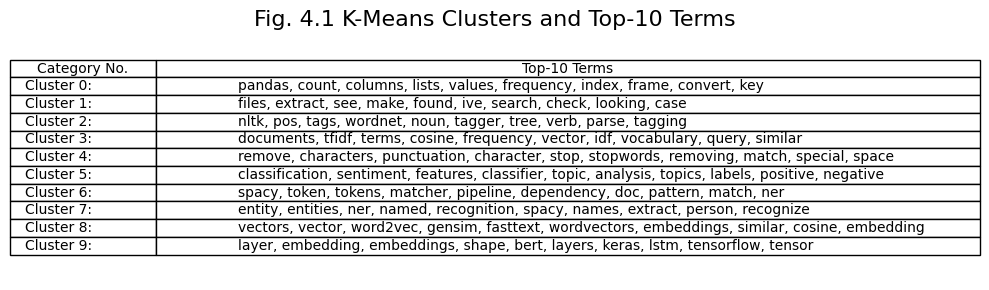

In [237]:
kmeans_clusters = name_category(kmeans_tfidf_model, tfidf_vectorizer)
visualize_categories_in_table(kmeans_clusters, title="Fig. 4.1 K-Means Clusters and Top-10 Terms")

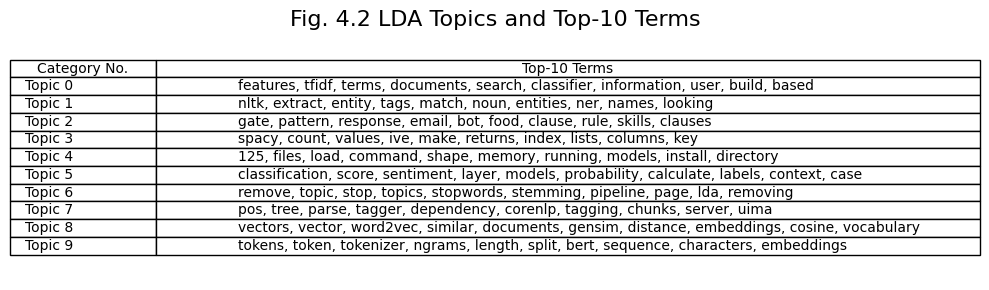

In [236]:
lda_topics = name_category(bow_lda, count_vectorizer)
visualize_categories_in_table(lda_topics, title="Fig. 4.2 LDA Topics and Top-10 Terms")

As can be seen from Fig. 4.1 and 4.2, Top-10 words of each category in K-Means seems easier to interpret and more coherent grouping than LDA. We can clearly see that cluster number 0 is about pandas or any kind of dataset operation. Cluster number 2 also shows a very distinctive area of NLP based on the top-10 words, which is POS Tagging, Syntatic and Semantic Parsing. Overall, K-Means has less overlap between categories and the words of each cluster relate closer to each other. It seems like there is a very distinctive boundaries of each cluster.

However, cluster number 1 in K-Means has a very vague terms based on its top-10 words. There is no specific term that can tell what area of NLP it covered. So, initially the name of this cluster was set as “Other Categories”.

In contrast, LDA is more difficult to name each extracted topic. There are some words from mixed concepts but grouped in one category. For instance, Topic 2 in Fig 4.2, there are some chatbot terminology (bot, response) but mixed with food terms and grammatical concepts (clauses, rules). Additionally, Topic 4 mixes file operations with model parameters ("125, files, load, command, shape, memory"), making it difficult to clearly define what the category represents.

Therefore, the interpretability to name each category decides which model that is used for final categorization. Since K-Means led in terms of coherence score and it also has better interpretability, K-Means will be used for final categorization. When naming categories is a primary goal, having cleanly separated clusters with minimal overlap is crucial, and K-Means has delivered this more effectively than LDA.


### 4.4 Assigning Category

Each SO question was assigned to a single category by using trained K-Means model. Herewith the code implementation

In [105]:
def map_cluster_to_category(cluster_number):
    kmeans_categories = {
        0: "Dataset Operation",
        1: "Other Categories",
        2: "POS Tagging, Syntatic, and Semantic Parsing",
        3: "TF-IDF Vectors and Text Similarity",
        4: "Text Preprocessing and Extraction",
        5: "Text Classification and Sentiment Analysis",
        6: "Spacy Usage",
        7: "Named Entity Recognition",
        8: "Word2Vec and Embedding Models",
        9: "Deep Learning and Contextual Vector Embeddings"
    }
    return kmeans_categories.get(cluster_number, "Unknown Category")

In [106]:
categorized_dataset = non_html_tags_desc_dataframe.copy()

categorized_dataset["cluster"] = kmeans_tfidf_model.labels_

categorized_dataset["category_name"] = categorized_dataset["cluster"].apply(map_cluster_to_category)

Herewith some example of several SO Questions that have been categorized:

In [246]:
categorized_dataset[["title", "link", "non_html_description", "non_html_answer","cluster", "category_name"]]

,title,link,non_html_description,non_html_answer,cluster,category_name
0,Save and reuse TfidfVectorizer in scikit learn,https://stackoverflow.com/questions/30843011/s...,I am using TfidfVectorizer in scikit learn to ...,"Firstly, it's better to leave the import at th...",1,Other Categories
3,NameError: name &#39;init_empty_weights&#39; i...,https://stackoverflow.com/questions/79559702/n...,I am trying to set up hugging face locally and...,"Try using this version, it should resolve the ...",1,Other Categories
8,Natural Language Processing Tag definitions,https://stackoverflow.com/questions/21514270/n...,When parsing and tagging the words with OpenNL...,The tags are part-of-speech tags or syntactic ...,2,"POS Tagging, Syntatic, and Semantic Parsing"
13,Why does Presidio with spacy nlp engine not re...,https://stackoverflow.com/questions/79549787/w...,I'm using spaCy with the pl_core_news_lg model...,The configuration file is missing the 'labels_...,7,Named Entity Recognition
20,Store images instead of showing in a server,https://stackoverflow.com/questions/79501178/s...,I am running the code found on this in my serv...,I can't test it but ... I checked and it uses ...,1,Other Categories
...,...,...,...,...,...,...
20407,NLP classify sentences/paragraph as funny,https://stackoverflow.com/questions/548951/nlp...,Is there a way to classify a particular senten...,"There is research on this, it's called . It's ...",1,Other Categories
20408,Algorithm for separating nonsense text from me...,https://stackoverflow.com/questions/501675/alg...,I provided some of my programs with a feedback...,How about just using some existing implementat...,1,Other Categories
20409,"Contextual Natural Language Resources, Where D...",https://stackoverflow.com/questions/127238/con...,Where can i find some .Net or conceptual resou...,To find resources in part of speech tagging (a...,1,Other Categories
20413,Shell script to find bigrams,https://stackoverflow.com/questions/245082/she...,"I'm making a shell script to find bigrams, whi...",Just replace the paste line with this: This wi...,1,Other Categories


Now we can export this into a csv that can be used for dataset in the future.

In [250]:
export_categorized_dataset = categorized_dataset.copy()[["title", "link", "non_html_description", "non_html_answer","cluster", "category_name",  
                                                         "attached_code_blocks", "attached_answer_code_blocks"]]

export_categorized_dataset = export_categorized_dataset.rename(columns={
    "non_html_description": "description",
    "non_html_answer": "answer"
})
export_categorized_dataset.to_csv(CATEGORIZED_DATA, mode="a", header=True, index=False, encoding="utf-8")

### 4.5 Insights

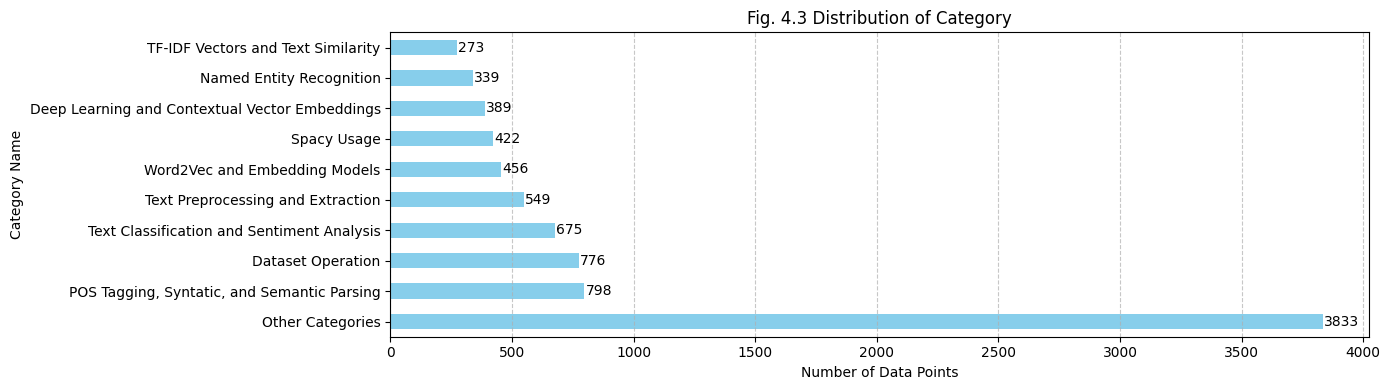

In [260]:
### Reference: ChatGPT 1

category_counts = categorized_dataset['category_name'].value_counts()

plt.figure(figsize=(14, 4))
bars = category_counts.plot(kind='barh', color='skyblue')
plt.ylabel('Category Name')
plt.xlabel('Number of Data Points')
plt.title(' ')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add count labels to the end of each bar
for i, v in enumerate(category_counts):
    plt.text(v + 5, i, str(v), va='center')

# Adjust layout to prevent label cutoff
plt.title("Fig. 4.3 Distribution of Category")
plt.tight_layout()
plt.show()

In [238]:
from sklearn.metrics import silhouette_score

cluster_labels = kmeans_tfidf_model.labels_

# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
print(f"The average silhouette score is: {silhouette_avg:.4f}")

The average silhouette score is: 0.0054


As can be seen on Fig. 4.3, approximately 55 percent of questions with accepted answers are categorized into a clearly defined NLP Category. Among this 55%, “POS Tagging, Syntatic, and Semantic Parsing” (798 questions) represents the most common NLP-related questions. Additionally, “Text Classification and Sentiment Analysis" (675) is in the mid-range number of questions, reflecting one of the most common practical applications of NLP. The appearance of tool-specific categories like "Spacy Usage" (422) also shows how technical communities often organize around particular libraries and frameworks. Therefore, this distribution can provide valuable insights regarding which NLP topics have the most frequent questions in Stack Overflow and indicate areas where developers commonly faced challenges.

On the other hand, the rest 45% falls into “Other Categories”. This large proportion indicates the K-Means model hardly identified specialized topic that is fit to many SO questions. This might be caused by many reasons, including many SO questions covered general programming questions that somehow happen to use NLP libraries, the broad and interdisciplinary nature of NLP, and questions that contain multiple NLP sub-domains. However, another critical reason for this result relates to the **low silhouette score (0.0054)** gained by the K-Means model. This score indicates that many SO questions is located at the boundaries in the vector space, indicating some conceptual overlap between categories. 

Despite these conceptual overlaps, the K-Means model can ensure non-overlapping categories by design. Every SO question is assigned to exactly one cluster based on its closest centroid in the vector space and technically distinct categories even when questions might relate to multiple NLP domains.


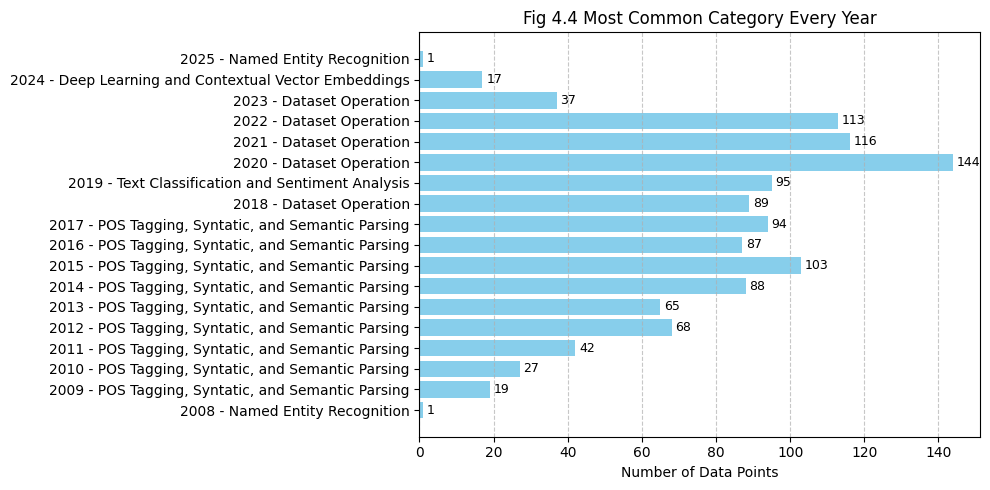

In [259]:
### Reference ChatGPT 1

# Filter out "other category"
filtered_categorized_dataset = categorized_dataset[categorized_dataset['category_name'] != 'Other Categories']

# Group by creation_year and category_name, then count entries
year_category_counts = (
    filtered_categorized_dataset
    .groupby(['creation_year', 'category_name'])
    .size()
    .reset_index(name='count')
)

# Get top 1 category per creation_year
top1_per_year = (
    year_category_counts
    .sort_values(['creation_year', 'count'], ascending=[True, False])
    .groupby('creation_year')
    .head(1)
)

# Combine year and category into label for plotting
top1_per_year['label'] = top1_per_year['creation_year'].astype(str) + ' - ' + top1_per_year['category_name']

# Plot in a single horizontal bar chart
plt.figure(figsize=(10, 5))
bars = plt.barh(top1_per_year['label'], top1_per_year['count'], color='skyblue')
plt.xlabel('Number of Data Points')
plt.title('')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add count labels
for i, (label, count) in enumerate(zip(top1_per_year['label'], top1_per_year['count'])):
    plt.text(count + 1, i, str(count), va='center', fontsize=9)
plt.title("Fig 4.4 Most Common Category Every Year")
plt.tight_layout()
plt.show()


In addition, once we ignore the “Other Categories” – as it does not give very meaningful insight –, we can see the top category that were discussed every year. Figure 4.4 illustrates that from 2009 to 2017, “POS Tagging, Syntatic, and Semantic Parsing” was the most asked topic in Stack Overflow. One of the reasons why this trend happened is, POS Tagging was a fundamental building block for many NLP tasks. 

Starting from 2018, “Dataset Operation” category seemed dominating the discussion on the platform. This change might be caused by the shifting of NLP to deep learning approach. This shifting phenomenon required developers and researchers handling big number of datasets for training and fine-tuning deep learning model. Therefore, it ended up raising more questions and discussion related data preparation. 

## 5. References

Bhavar, A. (2024, November 30). Mastering text preprocessing in generative AI and NLP projects. Medium. https://medium.com/@aniketbhavar0601/mastering-text-preprocessing-in-generative-ai-and-nlp-projects-e6aab5b2c784

Mistry, T. (2024, November 29). Text-PreProcessing — removing punctuation and special characters. Medium. https://medium.com/@mistrytejasm/text-preprocessing-removing-punctuation-and-special-characters-e3de4cece082

Hardeniya, N., Perkins, J., Chopra, D., Joshi, N., & Mathur, I. (n.d.). Natural language processing: Python and NLTK. O'Reilly Online Learning. https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch02s07.html

Saha, R. (2023, January). Influence of various text embeddings on clustering performance in NLP [Preprint]. arXiv. https://doi.org/10.48550/arxiv.2305.03144

Zvornicanin, E. (2025, February 28). When coherence score is good or bad in topic modeling? Baeldung on Computer Science. https://www.baeldung.com/cs/topic-modeling-coherence-score

Stevens, K., Kegelmeyer, P., Andrzejewski, D., & Buttler, D. (2012, July 1). Exploring topic coherence over many models and many topics. ACL Anthology. https://aclanthology.org/D12-1087/

ChatGPT 1: OpenAI 2025 ChatGPT v4.o, "barh example in python plt", Appendix A

ChatGPT 2: OpenAI 2025 ChatGPT v4.o, "example of WordCloud", Appendix B

ChatGPT 3: OpenAI 2025 ChatGPT v4.o, "example create table matplotlib", Appendix C

## 6. Appendix

### Appendix A

```
import matplotlib.pyplot as plt

# Sample data
categories = ['AI', 'Data Science', 'Web Dev', 'Mobile Dev']
values = [80, 65, 50, 45]

# Create horizontal bar chart
plt.barh(categories, values, color='skyblue')
plt.xlabel('Popularity')
plt.title('Popularity of Tech Fields')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

```


### Appendix B

```
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample text
text = "Python is great for data science, AI, machine learning, deep learning, and natural language processing."

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud Example')
plt.show()

```

### Appendix C

```
import matplotlib.pyplot as plt

# Sample data
columns = ('Name', 'Age', 'Country')
rows = [
    ['Alice', 24, 'USA'],
    ['Bob', 30, 'Canada'],
    ['Charlie', 28, 'UK']
]

# Create a figure and hide the axes
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axes

# Create the table
table = ax.table(cellText=rows, colLabels=columns, loc='center', cellLoc='center')

# Style the table
table.scale(1, 2)  # Adjust size: (width, height)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Show plot
plt.title("Sample Data Table")
plt.show()

```